In [22]:
import pandas as pd
import seaborn as sns
import os
cwd = os.getcwd()

In [23]:
train_df = pd.read_csv(r"C:\Users\agent\OneDrive\UM\project_2_1\rummicubei\data\training_data\train_baseline_vs_baseline_data.csv")
test_df = pd.read_csv(r"C:\Users\agent\OneDrive\UM\project_2_1\rummicubei\data\training_data\test_baseline_vs_baseline_data.csv")
metrics = pd.read_csv(r"C:\Users\agent\OneDrive\UM\project_2_1\rummicubei\machine_learning\model_files\20240122-09_05_14_metrics_epochs_40_batchSize1_l0.0005_loss_CrossEntropyLoss_opt_type.csv", header=1)

<Axes: xlabel='epoch', ylabel='loss'>

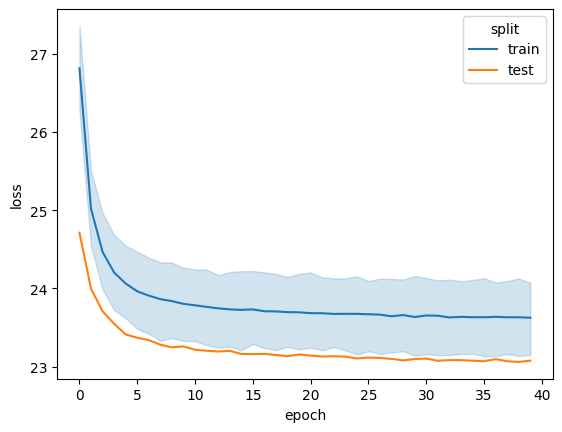

In [25]:
sns.lineplot(data=metrics, x="epoch", y="loss", hue="split") # shows the 95% confidence intervall

In [ ]:
sns.lineplot(data=metrics, x="epoch", y="accuracy", hue="split")